# Exploring Brain-Wide Inputs to the Secondary Motor Cortex with the Allen Connectivity Atlas

This project shows how the Allen Mouse Brain Connectivity Atlas can be used to investigate where inputs to a specific brain area come from. Using projection density data from multiple tracer experiments, the code groups injections by source region (e.g., auditory or visual cortices) and looks at how strongly they project to the secondary motor cortex (MOs). By comparing and correlating these inputs, we can get insights into how different sensory systems converge on motor areas — and the same approach could be applied to study afferents to any other brain nucleus or region of interest.

# 1. Set up
Packages to install and import

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')
%matplotlib inline

Import now data from the allen sdk repository

In [41]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
# MouseConnectivityCache has a method for retrieving the adult mouse structure 
# tree as an StructureTree class instance. This is a wrapper around a list of 
# dictionaries, where each dictionary describes a structure. 
# It is principally useful for looking up structures by their properties

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json') #relative path

In [42]:
# grab the StructureTree instance
structure_tree = mcc.get_structure_tree() # To see only structure sets relevant to the adult mouse brain, use the StructureTree

# get info on some structures
structures = structure_tree.get_structures_by_acronym(['MOs', 'SCs'])# You can also .get_structures_by_name(['Secondary motor area'])

In [43]:
# On the connectivity atlas web site, they show most of data at a fairly coarse structure level. 
# They did this by creating a structure set of ~300 structures, which we call the "summary structures". 
# We can use the structure tree to get all of the structures in this set
from allensdk.api.queries.ontologies_api import OntologiesApi

oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
structure_set_ids = structure_tree.get_structure_sets()

# 2. Function set up
A bunch of functions to run the code

In [44]:
#Function that computes percentiles of average template intensities in selected
#structures.
def get_median_template_intensity(mouse_connectivity_cache, structure_ids):
    
    mask = mouse_connectivity_cache.get_reference_space().make_structure_mask(structure_ids)
    template, _ = mouse_connectivity_cache.get_template_volume()
                        
    return np.percentile(template[mask > 0].flat, 50, interpolation='lower')

In [45]:
# function that determines the density of signal within a structure (i.e. the fraction of pixels
# in all the voxels in that structure that were detected as signal).
def fraction_of_structure(mouse_connectivity_cache, structure_id, experiment_id):
    
    mask, _ = mouse_connectivity_cache.get_structure_mask(structure_id)
    
    if mask.sum() == 0:
        return 0.0
    
    projection_density, _ = mouse_connectivity_cache.get_projection_density(experiment_id)
    projection_density[mask == 0] = 0
    
    fraction = projection_density.sum() / mask.sum()
    return fraction

In [46]:
def axis_proj(data, template, axis, bg_q=90, bg_alpha=0.5):
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=plt.cm.afmhot)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    plt.axis('off')  # Hide x and y axes

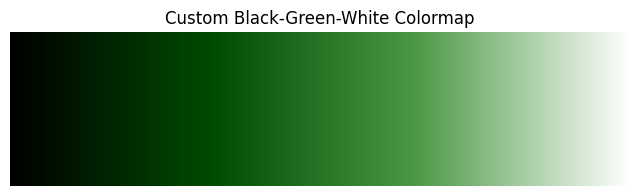

In [87]:
# Define custom colormap: black -> green -> white
green_palette = [(0.00, "#000000"),
                 (0.33, "#004D00"),
                 (0.66, "#4E9A4A"),
                 (1.00, "#FFFFFF")
                 ]



# Create colormap
custom_green_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_cmap", green_palette)
custom_cmap_ratio = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors_ratio)

# Show colormap example
gradient = np.linspace(0, 1, 256).reshape(1, -1)  # Create a gradient for visualization
plt.figure(figsize=(8, 2))
plt.imshow(gradient, aspect='auto', cmap=custom_green_cmap)
plt.axis('off')
plt.title("Custom Black-Green-White Colormap")
plt.show()

In [132]:
def axis_proj_green(data, template, axis, bg_q=90, bg_alpha=0.5, pixel_size_um=25, scalebar_um=500):
    """
    To plot the density projections with the green colorbar
    """
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    ax = plt.gca()  # use current axes  

    ax.imshow(data_max, interpolation='none', cmap=custom_green_cmap)
    ax.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    ax.axis('off')  # Hide x and y axes

    # --- Add scale bar in top left ---
    scalebar_px = int(scalebar_um / pixel_size_um)
    bar_height = max(4, int(0.02 * data_max.shape[0]))  # 4 pixels or 2% of image height
    ax.add_patch(
        patches.Rectangle((10, 10), scalebar_px, bar_height, color='white', lw=0)
    )
    ax.text(10, 10 + bar_height + 10, f'{scalebar_um} µm',
            color='white', fontsize=5, ha='left', va='top')

In [84]:
def axis_proj_green_outline(data, template, axis, bg_q=90, bg_alpha=0.5, structure_masks=None, default_color="white"):
    """
    Plot density projections in magenta with an outline for specified structure masks.
    """
    # Projection of data & template
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)

    ax = plt.gca()  # use current axes

    # Plot projections
    ax.imshow(data_max, interpolation='none', cmap=custom_green_cmap)
    ax.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=bg_alpha)
    ax.axis('off')

    # Overlay outlines for each structure
    if structure_masks is not None:
        mask_proj = np.amax(structure_masks, axis=axis)
        if np.any(mask_proj):
            ax.contour(mask_proj, levels=[0.5], colors=default_color, linewidths=0.8)


In [ ]:
# version with scale bar

def axis_proj_green_outline(data, template, axis, bg_q=90, bg_alpha=0.5, structure_masks=None, default_color="white", pixel_size_um=25, scalebar_um=500):
    """
    Plot density projections in magenta with an outline for specified structure masks.
    """
    # Projection of data & template
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)

    ax = plt.gca()  # use current axes

    # Plot projections
    ax.imshow(data_max, interpolation='none', cmap=custom_green_cmap)
    ax.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=bg_alpha)
    ax.axis('off')

    # Overlay outlines for each structure
    if structure_masks is not None:
        mask_proj = np.amax(structure_masks, axis=axis)
        if np.any(mask_proj):
            ax.contour(mask_proj, levels=[0.5], colors=default_color, linewidths=0.8)

    # --- Add scale bar in top left ---
    scalebar_px = int(scalebar_um / pixel_size_um)
    bar_height = max(4, int(0.02 * data_max.shape[0]))  # 4 pixels or 2% of image height
    ax.add_patch(
        patches.Rectangle((10, 10), scalebar_px, bar_height, color='white', lw=0)
    )
    ax.text(10, 10 + bar_height + 10, f'{scalebar_um} µm',
            color='white', fontsize=5, ha='left', va='top')

In [51]:
def sign_preserving_projection(data, axis):
    """
    For each (x,y) in the projected plane, select the element along the given axis
    with the largest absolute value, and return that value.
    """
    abs_data = np.abs(data)
    idx = np.argmax(abs_data, axis=axis)
    
    # Use np.take_along_axis to retrieve the values along the specified axis
    proj = np.take_along_axis(data, np.expand_dims(idx, axis=axis), axis=axis)
    # Remove the extra axis
    proj = np.squeeze(proj, axis=axis)
    return proj

In [122]:
import matplotlib.patches as patches

def slice_hsv_overlay(selectivity_index, sum_matrix, template, slice_index, axis=1, ax=None, bg_q=90, bg_alpha=1, structure_masks=None, pixel_size_um=25, scalebar_um=500):
    if ax is None:
        fig, ax = plt.subplots()

    # Select the appropriate 2D slice
    if axis == 0:
        si_slice = selectivity_index[slice_index, :, :]
        sm_slice = sum_matrix[slice_index, :, :]
        bg_slice = template[slice_index, :, :]
    elif axis == 1:
        si_slice = selectivity_index[:, slice_index, :]
        sm_slice = sum_matrix[:, slice_index, :]
        bg_slice = template[:, slice_index, :]
    elif axis == 2:
        si_slice = selectivity_index[:, :, slice_index]
        sm_slice = sum_matrix[:, :, slice_index]
        bg_slice = template[:, :, slice_index]
    else:
        raise ValueError("Axis must be 0, 1, or 2")

    # Normalize and convert HSV to RGB
    sm_norm = np.full_like(sm_slice, np.nan, dtype=np.float32)
    non_zero_mask = sm_slice > 0
    if np.any(non_zero_mask):
        sm_norm[non_zero_mask] = sm_slice[non_zero_mask] / np.nanmax(sm_slice[non_zero_mask])
    else:
        sm_norm[:] = 0

    #hue = np.where(si_slice >= 0, 1/3, 5/6)  # Green or Magenta
    # Map from [-1, 1] → [1/3, 0.75] (green to cyan to magenta)
    si_clipped = np.clip(si_slice, -1, 1)
    hue = (1 - (si_clipped + 1) / 2) * (5/6 - 1/3) + 1/3
    #hue = np.full_like(si_slice, 0.5)  # default to light blue (approx. 0.5 in HSV)
    #hue[si_slice <= -0.25] = 5/6       # green (~0.33)
    #hue[si_slice >= 0.25] = 1/3        # magenta (~0.83)
    #saturation = np.abs(si_slice)      # to have saturation variable in the map
    saturation = np.ones_like(si_slice)
    #value = sm_norm
    value = np.ones_like(saturation)

    alpha_channel = sm_norm
    alpha_channel[~non_zero_mask] = 0
    
    hsv_image = np.stack((hue, saturation, value), axis=-1)
    rgb_image = hsv_to_rgb(hsv_image)
    # Combine RGB and alpha to create an RGBA image
    rgba_image = np.dstack((rgb_image, alpha_channel))

    #alpha = np.abs(si_slice)
    #alpha[~non_zero_mask] = 0

    # Plot anatomical background
    ax.imshow(bg_slice, cmap='gray', alpha=bg_alpha, interpolation='none')

    # Plot HSV overlay
    ax.imshow(rgba_image, interpolation='none')

    # Overlay the structure mask (e.g., MOs)
    if structure_masks is not None:
        for region_name, (mask, color) in structure_masks.items():
            # Extract slice for the current axis
            if axis == 0:
                mask_slice = mask[slice_index, :, :]
            elif axis == 1:
                mask_slice = mask[:, slice_index, :]
            elif axis == 2:
                mask_slice = mask[:, :, slice_index]
            else:
                raise ValueError("Invalid axis. Use 0, 1, or 2.")
            # Plot contour if the mask slice has nonzero data
            if np.any(mask_slice):
                ax.contour(mask_slice, levels=[0.5], colors=color, linewidths=0.2)
    
    # Add scale bar in top left
    scalebar_px = int(scalebar_um / pixel_size_um)
    bar_height = max(2, int(0.01 * bg_slice.shape[0]))  # 2 pixels or 1% of image height
    ax.add_patch(
        patches.Rectangle((5, 5), scalebar_px, bar_height, color='white', lw=0)
    )
    ax.text(5 + scalebar_px / 2, 5 + bar_height + 10, f'{scalebar_um} µm',
            color='white', fontsize=8, ha='center', va='top')

    ax.axis('off')

# 3. Structure signal unionization
The ProjectionStructureUnionizes API data tells you how much signal there was in a given structure and experiment. It contains the density of projecting signal, volume of projecting signal, and other information. MouseConnectivityCache provides methods for querying and storing this data.

In [53]:
# find wild-type injections into visual areas
vis = structure_tree.get_structures_by_acronym(['VIS'])[0]
print(vis)

vis_experiments = mcc.get_experiments(cre=False, 
                                       injection_structure_ids=[vis['id']])

print("%d VIS experiments" % len(vis_experiments))

{'acronym': 'VIS', 'graph_id': 1, 'graph_order': 157, 'id': 669, 'name': 'Visual areas', 'structure_id_path': [997, 8, 567, 688, 695, 315, 669], 'structure_set_ids': [3, 112905828, 691663206, 12, 184527634, 112905813, 114512891, 114512892], 'rgb_triplet': [8, 133, 140]}
47 VIS experiments


In [54]:
mop = structure_tree.get_structures_by_acronym(['MOp'])[0]
print(mop)

{'acronym': 'MOp', 'graph_id': 1, 'graph_order': 18, 'id': 985, 'name': 'Primary motor area', 'structure_id_path': [997, 8, 567, 688, 695, 315, 500, 985], 'structure_set_ids': [112905828, 688152357, 691663206, 687527945, 12, 184527634, 167587189, 112905813, 114512891, 114512892], 'rgb_triplet': [31, 157, 90]}


Get data for single experiments - to retreive them, you can use this piece of code, else go to the allen connectivity website if you want to be more specific and see which other options are available for selecting experiments
https://connectivity.brain-map.org/

In [55]:
# Step 1: Get the structure ID for the auditory areas and visual areas
experiment_ids_vis = []

vis = structure_tree.get_structures_by_acronym(['VIS'])[0]
vis_id = vis['id']

for exp in vis_experiments:
    experiment_ids_vis.append(exp['id'])

# 4. Manipulating grid data
The MouseConnectivityCache class also helps you download and open every experiment's projection grid data volume. By default it will download 25um volumes, but you could also download data at other resolutions if you prefer (10um, 50um, 100um).

This demonstrates how you can load the projection density for a particular experiment. It also shows how to download the template volume to which all grid data is registered. Voxels in that template have been structurally annotated by neuroanatomists and the resulting labels stored in a separate annotation volume image.

In [56]:
# injection into AUD as example
experiment_id = 146858006

In [57]:
# projection density: number of projecting pixels / voxel volume
proj_d, proj_d_info = mcc.get_projection_density(experiment_id)

# injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(experiment_id)

# injection fraction: number of pixels in injection site / voxel volume
inf, inf_info = mcc.get_injection_fraction(experiment_id)

# data mask:
# binary mask indicating which voxels contain valid data
dm, dm_info = mcc.get_data_mask(experiment_id)

template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

# in addition to the annotation volume, you can get binary masks for individual structures
# in this case, we'll get one for the MOs
cortex_mask, cm_info = mcc.get_structure_mask(993)

print(proj_d_info)
print(proj_d.shape, template.shape, annot.shape)

OrderedDict([('type', 'double'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([528, 320, 456])), ('space directions', array([[25.,  0.,  0.],
       [ 0., 25.,  0.],
       [ 0.,  0., 25.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])
(528, 320, 456) (528, 320, 456) (528, 320, 456)


# 5. Working in 3D
Allen Institute has generated an average template volume from 1675 mouse brain image stacks and registering each connectivity datasets to this average template. This allows us to work in a shared 3d space, which we call the Common Coordinate Framework (CCF).
You can view the average template volume using your MouseConnectivityCache.

The template is oriented:

anterior -> posterior

superior -> inferior

left -> right

This means that to obtain a sagittal view, we must slice along axis 2, and along axis 1 for a horizontal section (0=coronal, 1=horizontal, 2=sagittal):

(528, 320, 456)


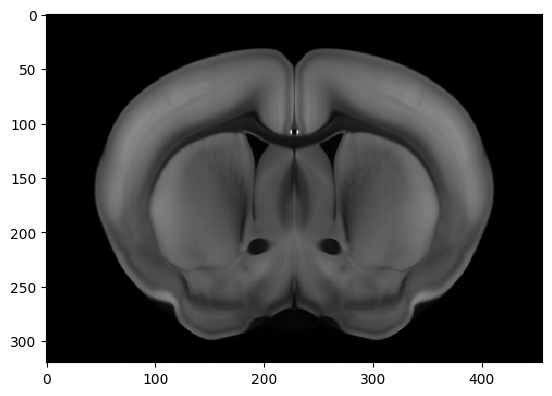

In [58]:
# load up the average template
template, header = mcc.get_template_volume()

# recall that this cache is at 25 micron isometric resolution
plt.imshow(template[200, :, :], interpolation='none', cmap=plt.cm.gray)

# how big?
print(template.shape)

# 8. Structure Mask
The annotation volume and structure tree contain a lot of information in a compact form. It can be simpler to work with more explicit representations of individual structures. We often use binary indicator masks for specific structures. These are:

volumes in the common coordinate framework

1 where the annotation is labeled with a structure or its descendants, otherwise 0

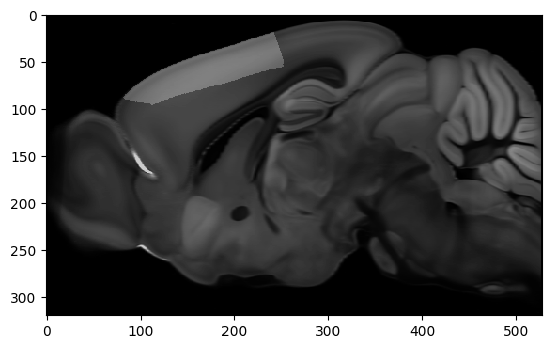

In [59]:
# view a structure mask for MOs
MOs_mask, _ = mcc.get_structure_mask(993) # 993 is the structure ID for MOs
plt.imshow(MOs_mask[:, :, 200].T, interpolation='none', cmap=plt.cm.gray)
plt.imshow(template[:, :, 200].T, interpolation='none', cmap=plt.cm.gray, alpha=0.8)

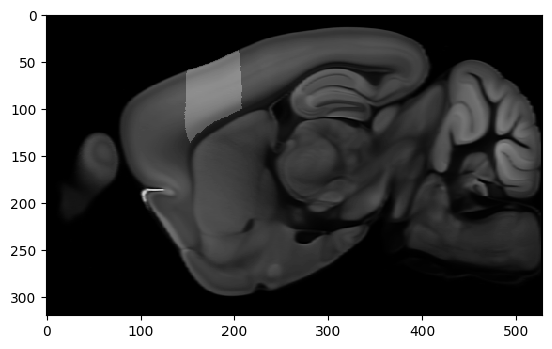

In [60]:
# view a structure mask for MOp
MOp_mask, _ = mcc.get_structure_mask(985) # 985 is the structure ID for MOp
plt.imshow(MOp_mask[:, :, 150].T, interpolation='none', cmap=plt.cm.gray)
plt.imshow(template[:, :, 150].T, interpolation='none', cmap=plt.cm.gray, alpha=0.8)

# 9. Gridded projection data
Since each connectivity experiment is registered to the CCF, we can load connectivity data in the same way as we do the average template or annotation volume.

Here we will load an experiment's projection density volume. These data:

- are floats in [0, 1]

- represent the fraction of each voxel that is occupied by signal (as detected in the segmentation stage)

- are independent of the injection site (so it makes sense to discuss "projection in the injection site")

In [61]:
# Compute Average Projection Density from multiple experiments

# Initialize an array to accumulate projection densities
average_prdens_vis = None

# Iterate through experiment IDs
for exp_id in experiment_ids_vis:
    prdens_vis, _ = mcc.get_projection_density(exp_id)  # Load projection density for the experiment
    if average_prdens_vis is None:
        # Initialize the accumulator with the shape of the first experiment's data
        average_prdens_vis = np.zeros_like(prdens_vis, dtype=np.float32)
    average_prdens_vis += prdens_vis
    
# Compute the average
average_prdens_vis /= len(experiment_ids_vis)

I am using different colors to distinguish the different areas projectiong to the MOs.
- Magenta for Visual Areas
- Green for Auditory Areas
- Blue for the combination of the two 

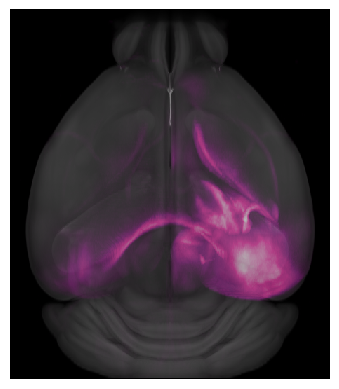

In [63]:
axis_proj_magenta(average_prdens_vis, template, 1)

In [64]:
#Get masks from multiple frontal areas
MO_mask, _ = mcc.get_structure_mask(500) # 500 is the structure ID for MO (MOs + MOp)

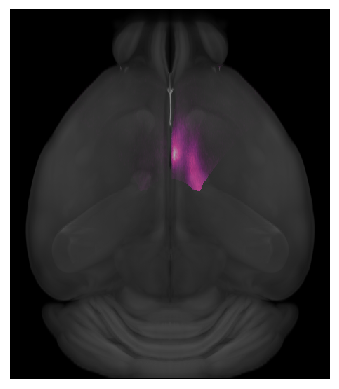

In [65]:
prdens_MO = average_prdens_vis.copy()
prdens_MO[MO_mask == 0] = 0
axis_proj_magenta(prdens_MO, template, 1) 

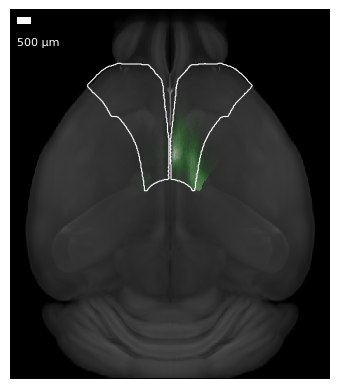

In [119]:
axis_proj_green_outline(prdens_MO, template, 1, structure_masks = MOs_mask)

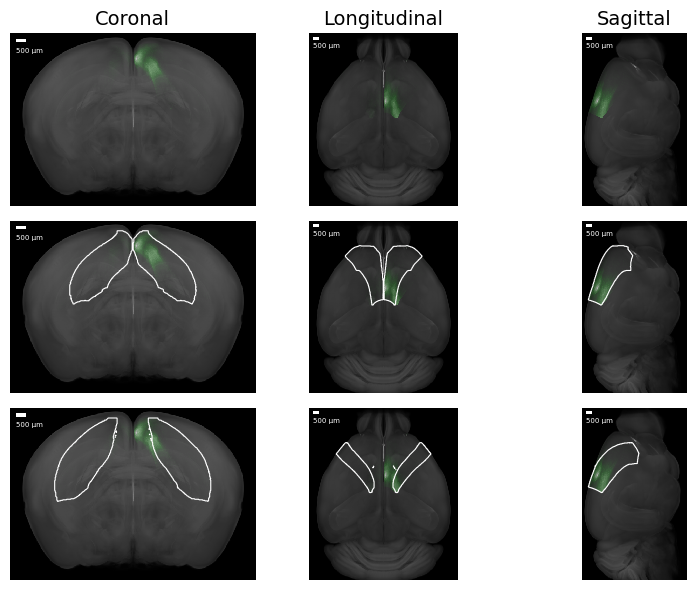

In [133]:
fig, axes = plt.subplots(3, 3, figsize=(8,6))  # 3 rows, 3 columns

# --- Row 1: MOs+MOp (magenta) ---
prdens_MO = average_prdens_vis.copy()
prdens_MO[MO_mask == 0] = 0
plt.sca(axes[0,0]); axis_proj_green(prdens_MO, template, 0)
plt.sca(axes[0,1]); axis_proj_green(prdens_MO, template, 1)
plt.sca(axes[0,2]); axis_proj_green(prdens_MO, template, 2)

# --- Row 2: MOs outline
prdens_MO = average_prdens_vis.copy()
prdens_MO[MO_mask == 0] = 0
plt.sca(axes[1, 0]); axis_proj_green_outline(prdens_MO, template, 0, structure_masks = MOs_mask)
plt.sca(axes[1, 1]); axis_proj_green_outline(prdens_MO, template, 1, structure_masks = MOs_mask)
plt.sca(axes[1, 2]); axis_proj_green_outline(prdens_MO, template, 2, structure_masks = MOs_mask)

# --- Row 3: MOp outline
prdens_MO = average_prdens_vis.copy()
prdens_MO[MO_mask == 0] = 0
plt.sca(axes[2, 0]); axis_proj_green_outline(prdens_MO, template, 0, structure_masks = MOp_mask)
plt.sca(axes[2, 1]); axis_proj_green_outline(prdens_MO, template, 1, structure_masks = MOp_mask)
plt.sca(axes[2, 2]); axis_proj_green_outline(prdens_MO, template, 2, structure_masks = MOp_mask)

# --- Column titles ---
col_titles = ["Coronal", "Longitudinal", "Sagittal"]
for j, title in enumerate(col_titles):
    axes[0, j].set_title(title, fontsize=14)

# --- Row labels ---
row_labels = ["No outline", "MOs outline", "MOp outline"]
for i, label in enumerate(row_labels):
    axes[i, 0].set_ylabel(label, fontsize=14, rotation=90, labelpad=15)

# --- Formatting ---
#for ax_row in axes:
#    for ax in ax_row:
#        ax.axis("off")

plt.tight_layout()
plt.savefig('MOs_MOp_plot.svg', format='svg')
plt.show()



In [108]:
# Step 1: Sum overlapping active pixels
combined_prdens_sum = np.full_like(average_prdens_aud, np.nan, dtype=np.float32)
print("Sum Range in nan matrix:", np.min(combined_prdens_sum), np.max(combined_prdens_sum)) #Check they are all nan
combined_prdens_sum[overlap_active] = (
    average_prdens_aud[overlap_active] + average_prdens_vis[overlap_active]
)
print("Sum Range in summed matrix:", np.nanmin(combined_prdens_sum), np.nanmax(combined_prdens_sum)) #Check max and min value excluding nan
print("Active pixels in sum matrix:", np.count_nonzero(~np.isnan(combined_prdens_sum))) #check number active pixels in sum matrix, should be the same of the true pixels in overlap_active matrix
print("Size of sum matrix:", combined_prdens_sum.size) #check size sum matrix is not the same value of the number of active values


# Step 2: Apply a new threshold (1% of the max value of combined_prdens_sum)
sum_threshold = 0.01 * np.nanmax(combined_prdens_sum)
print("1% threshold value:", sum_threshold) #check this is not nan
selected_pixels = combined_prdens_sum > sum_threshold # Creates a 3D matrix of True or False
print("True pixels after 1% of max value thresholding:", np.count_nonzero(selected_pixels)) #check number of True pixels

# Step 3: Create a new 3D matrix with selectivity index
selectivity_index = np.full_like(average_prdens_aud, np.nan, dtype=np.float32)
print("Selectivity Range:", np.min(selectivity_index), np.max(selectivity_index)) #check they are all nan

# Identify valid pixels: where both active and above the new threshold
print("True pixels that are active overall:", np.count_nonzero(overlap_active)) #check number of True pixels
valid_pixels = overlap_active & selected_pixels

# Calculate the selectivity index only for valid pixels
A = average_prdens_aud[valid_pixels]
print("Aud Range:", np.min(A), np.max(A)) #check their values

B = average_prdens_vis[valid_pixels]
print("Vis Range:", np.min(B), np.max(B))#check their values

selectivity_index[valid_pixels] = (A - B) / (A + B)
print("Selectivity Index Range:", np.nanmin(selectivity_index), np.nanmax(selectivity_index)) #check they are not nan

Sum Range in nan matrix: nan nan
Sum Range in summed matrix: 0.030036347 0.93267214
Active pixels in sum matrix: 1636649
Size of sum matrix: 77045760
1% threshold value: 0.00932672142982483
True pixels after 1% of max value thresholding: 1636649
Selectivity Range: nan nan
True pixels that are active overall: 1636649
Aud Range: 0.015000019 0.7673046
Vis Range: 0.015000007 0.54269475
Selectivity Index Range: -0.94247293 0.9587798


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.130738e+30..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.130738e+30..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.130738e+30..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.130738e+30..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.130738e+30..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.130738e+30..1.0].


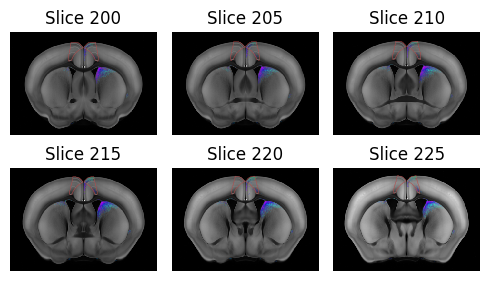

In [110]:
from matplotlib.colors import hsv_to_rgb, Normalize, LinearSegmentedColormap

# Show coronal slice 200
#From 20 to 150

# Settings
start_slice = 20
end_slice = 150
step = 5
axis = 1  # e.g., 0 = coronal, 1 = horizontal, 2 = sagittal

MOs_mask, _ = mcc.get_structure_mask(993)
MOs1_mask, _ = mcc.get_structure_mask(656)
MOs2_3_mask, _ = mcc.get_structure_mask(962)
MOs5_mask, _ = mcc.get_structure_mask(767)
MOs6a_mask, _ = mcc.get_structure_mask(1021)
MOs6b_mask, _ = mcc.get_structure_mask(1085)
combined_mask = (
    MOs1_mask |
    MOs2_3_mask |
    MOs5_mask |
    MOs6a_mask |
    MOs6b_mask
)

region_masks = {
    'MOs':     (MOs_mask, 'red'),
    'MOs1':    (MOs1_mask, 'grey'),
    'MOs2/3':  (MOs2_3_mask, 'grey'),
    'MOs5':    (MOs5_mask, 'grey'),
    'MOs6a':   (MOs6a_mask, 'grey'),
    'MOs6b':   (MOs6b_mask, 'grey')
}

fig, axes = plt.subplots(2, 3, figsize=(5,3))
axes = axes.flatten()

for i in range(6):
    slice_idx =200 + i * 5
    ax = axes[i]
    slice_hsv_overlay(
        selectivity_index,
        combined_prdens_sum,
        template,
        slice_index=slice_idx,
        axis=0,
        ax=ax,
        structure_masks=region_masks  # Pass the dict of region masks + colors
    )
    ax.set_title(f"Slice {slice_idx}")




plt.tight_layout()

You can also save these different slices in a gif, to have a fancy video to look at to better understand MOs projection from VIS and AUD areas and their contribution (it may take a while)

In [111]:
import imageio.v2 as imageio
import os

# Create directory to store frames
os.makedirs("frames", exist_ok=True)
filenames = []

# Generate frames with higher resolution (e.g., 6 inches × 4 inches at 200 DPI)
for i in range(263):
    slice_idx = 0 + i * 2
    fig, ax = plt.subplots(figsize=(10, 12), dpi=100)

    slice_hsv_overlay(
        selectivity_index,
        combined_prdens_sum,
        template,
        slice_index=slice_idx,
        axis=0,
        ax=ax,
        structure_masks=region_masks
    )
    
    ax.set_title(f"Slice {slice_idx}", fontsize=10)
    ax.axis("off")

    fname = f"frames/frame_{i:02d}.png"
    fig.savefig(fname, bbox_inches="tight")
    filenames.append(fname)
    plt.close(fig)

# Make the loop smooth by going forward and then backward
loop_filenames = filenames + filenames[::-1][1:-1]

# Create a looping GIF with 10 fps (0.1 sec per frame)
with imageio.get_writer("stack_slices_loop.gif", mode="I", duration=0.1, loop=0) as writer:
    for fname in loop_filenames:
        image = imageio.imread(fname)
        writer.append_data(image)

print("GIF saved as 'stack_slices_loop.gif' with higher resolution and smooth looping.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.130738e+30..3.9453125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.130738e+30..3.5409453e-34].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4841185e+21].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.801752e+29..1.6959655e+21].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.130738e+30..1.5904552e+21].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.1306797e+30..1.5904552e+21].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for in

GIF saved as 'stack_slices_loop.gif' with higher resolution and smooth looping.


# 10. Correlation Analysis
I try to plot correlation matrices for MOs active pixels between different subregions in the VIs and AUD cortices

In [91]:
# Get all experiments metadata
all_experiments = mcc.get_experiments(dataframe=True)

# Get metadata for the vis and aud experiments
vis_meta = all_experiments[all_experiments['id'].isin(experiment_ids_vis)]

In [94]:
# Group experiments by injection structure
vis_groups = vis_meta.groupby('structure_abbrev')

vis_groups

In [95]:
# Check which experiment IDs are in each group
for name, group in vis_groups:
    print(f"Group: {name}")
    print("Experiment IDs in this group:", list(group['id']))
    print("Unique structure_abbrev values in this group:", group['structure_abbrev'].unique())
    print("Number of experiments:", len(group))
    print("-" * 40)

Group: VISal
Experiment IDs in this group: [120437703]
Unique structure_abbrev values in this group: ['VISal']
Number of experiments: 1
----------------------------------------
Group: VISam
Experiment IDs in this group: [126861679, 100148503, 100141599]
Unique structure_abbrev values in this group: ['VISam']
Number of experiments: 3
----------------------------------------
Group: VISl
Experiment IDs in this group: [146858755, 116903968, 307295727, 114250546]
Unique structure_abbrev values in this group: ['VISl']
Number of experiments: 4
----------------------------------------
Group: VISli
Experiment IDs in this group: [100141796, 112373830]
Unique structure_abbrev values in this group: ['VISli']
Number of experiments: 2
----------------------------------------
Group: VISp
Experiment IDs in this group: [307297141, 113887162, 180296424, 100147853, 307321674, 304586645, 307558646, 307320960, 307743253, 113887868, 307557934, 114008926, 309003780, 277712166, 304565427, 277616630, 277714322

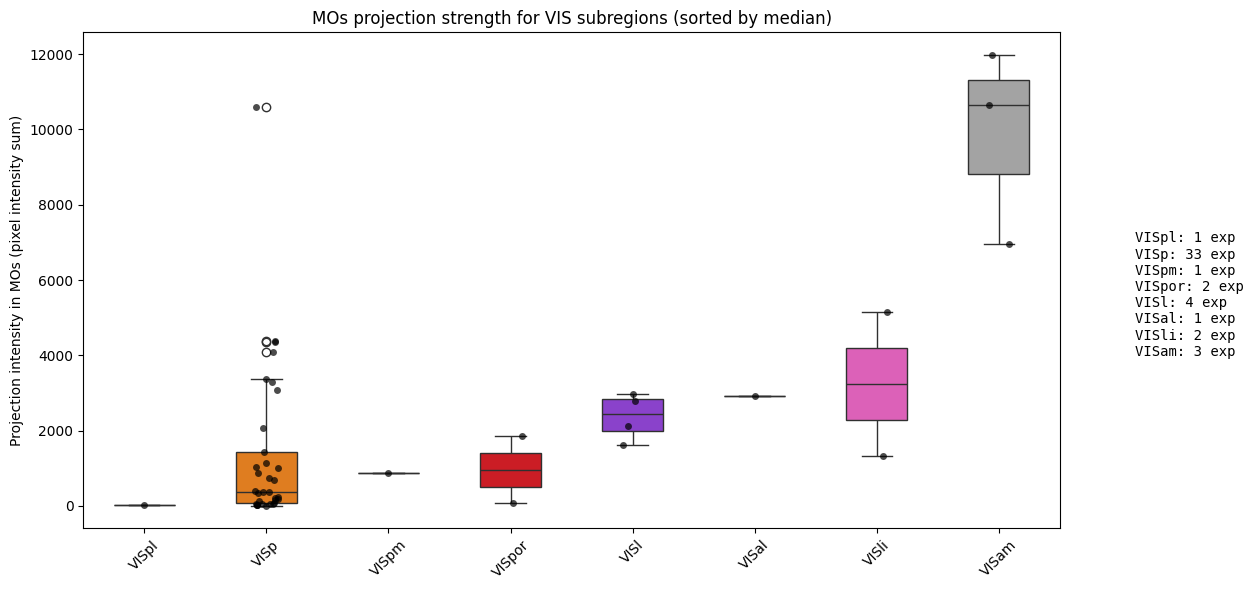

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dictionary to store normalized projection values per group
group_results = {}
group_counts = {}

# Loop through VIS groups
for name, group in vis_groups:
    group_values = []
    
    for _, row in group.iterrows():
        exp_id = row['id']
        inj_vol = row['injection_volume']

        # Load projection density for this experiment
        pr_map, _ = mcc.get_projection_density(exp_id)

        # Sum projection density values inside MOs safely
        summed_proj = np.nansum(pr_map * (MOs_mask > 0))

        # Normalize by injection volume
        #norm_proj = summed_proj / inj_vol if inj_vol > 0 else np.nan
        group_values.append(summed_proj)

    # Store results for this group
    group_results[name] = group_values
    group_counts[name] = len(group)  # store number of experiments

# ------------------------------
# 📊 Plot boxplots
# ------------------------------
# Compute medians for each group
group_medians = {name: np.nanmedian(vals) for name, vals in group_results.items()}

# Sort area names by median value (ascending)
ordered_vis = sorted(group_medians, key=group_medians.get)

# Filter and order data
ordered_data = [group_results[name] for name in ordered_vis if name in group_results]

plt.figure(figsize=(12, 6))
sns.boxplot(data=ordered_data, orient="v", width=0.5, palette="bright")
sns.stripplot(data=ordered_data, orient="v", jitter=True, color="black", alpha=0.7)

plt.xticks(range(len(ordered_vis)), ordered_vis, rotation=45)
plt.ylabel("Projection intensity in MOs (pixel intensity sum)")
plt.title("MOs projection strength for VIS subregions (sorted by median)")

# Legend with counts (ordered)
legend_text = "\n".join([f"{name}: {group_counts.get(name, 0)} exp" for name in ordered_vis])
plt.gcf().text(0.95, 0.5, legend_text, va='center', ha='left', fontsize=10, family="monospace")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('VIS_MOs_ProjectionStrength_sorted.svg', format='svg')
plt.show()
